In [1]:
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical

import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm as log_progress

In [5]:
#load and clean data
MODEL_NAME = "Test"
#MODEL_NAME = 'shakespear2.0'
data_file_name = "data.txt"
SEQUENCE_LENGTH = 7 #how many items are fed into the ai per sequence

raw = open("data/" + data_file_name, "r", encoding='utf-8')

lines = []
print("Loading data...")
for line in log_progress(raw):
    if str(line) != '\n':
        lines.append(str(line).lower())

print("Tokenizing...")
#putting the entirety of the input data into one string
text = ""
for line in log_progress(lines):
    text += line
tokenizer = RegexpTokenizer(r'[a-zA-Z]')
#tokenizer = RegexpTokenizer(r'\w+')
#tokenized = tokenizer.tokenize(text)
tokenized = [item for item in text]

#converting the text into numbers to be processed by the embedding layer of the model
words = [] #one of each word in tokenized will be in here
filtering = lambda x : not x in words #for finding if the word should be added to the words array
find = lambda x : float(words.index(x)) if x in words else float(len(words)) #convert each word into a number. -1 means that the item isn't in the vocabulary
normalize = lambda x: [find(i)/len(words) for i in x]

print("Finding every unique word...")
for word in log_progress(tokenized):
    if filtering(word):
        words.append(word)

#x data is every single word in the data set, in order
#y data is every single word that comes after the corresponding x value
x = []
y = []
charX = []
charY = []
print("Compiling dataset...")
counter = 0
for i in log_progress(range(int(len(tokenized) - SEQUENCE_LENGTH))):
    x.append(normalize(tokenized[i:i+SEQUENCE_LENGTH]))
    y.append(find(tokenized[i+SEQUENCE_LENGTH]))

x = np.asarray(x, np.float32)
y = np.asarray(y, np.int32)

x = np.reshape(x, (x.shape[0], 1, SEQUENCE_LENGTH))
y = to_categorical(y)

print(x.shape)
print(y.shape)

vocab_size = len(words)

Loading data...


0it [00:00, ?it/s]

Tokenizing...


  0%|          | 0/2309 [00:00<?, ?it/s]

Finding every unique word...


  0%|          | 0/99920 [00:00<?, ?it/s]

Compiling dataset...


  0%|          | 0/99913 [00:00<?, ?it/s]

(99913, 1, 7)
(99913, 38)


In [16]:
#create and compile model
model = Sequential()

#model.add(Embedding(vocab_size+1, 32, input_length=SEQUENCE_LENGTH)) #embedding: size of vocabulary, dimension of each value
model.add(LSTM(256, input_shape=(1, SEQUENCE_LENGTH), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))

opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 256)            270336    
                                                                 
 dropout_8 (Dropout)         (None, 1, 256)            0         
                                                                 
 lstm_9 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 38)                4902      
                                                                 
Total params: 472,358
Trainable params: 472,358
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/50
2967/2967 [==============================] - 25s 8ms/step - loss: 2.5631 - accuracy: 0.2845 - val_loss: 2.3584 - val_accuracy: 0.3265
Epoch 2/50
2967/2967 [==============================] - 21s 7ms/step - loss: 2.3485 - accuracy: 0.3296 - val_loss: 2.2489 - val_accuracy: 0.3451
Epoch 3/50
2967/2967 [==============================] - 20s 7ms/step - loss: 2.2602 - accuracy: 0.3458 - val_loss: 2.1648 - val_accuracy: 0.3659
Epoch 4/50
2967/2967 [==============================] - 20s 7ms/step - loss: 2.2069 - accuracy: 0.3578 - val_loss: 2.1533 - val_accuracy: 0.3703
Epoch 5/50
2967/2967 [==============================] - 20s 7ms/step - loss: 2.1643 - accuracy: 0.3667 - val_loss: 2.1014 - val_accuracy: 0.3785
Epoch 6/50
2967/2967 [==============================] - 20s 7ms/step - loss: 2.1430 - accuracy: 0.3713 - val_loss: 2.0801 - val_accuracy: 0.3927
Epoch 7/50
2967/2967 [==============================] - 20s 7ms/step - loss: 2.1196 - accuracy: 0.3765 - val_loss: 2.0500 - val_ac

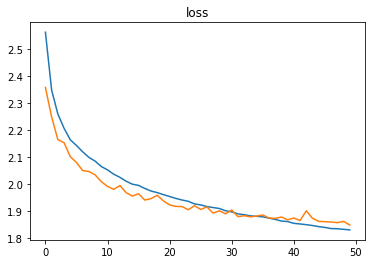

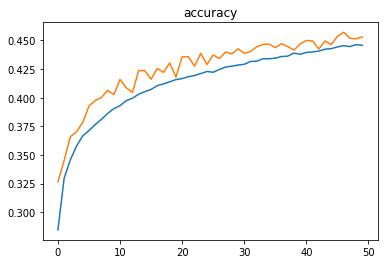

In [17]:
#train model
hist = model.fit(x, y, epochs=50, verbose=1, batch_size=32, shuffle=False, validation_split=0.05)
model.save(MODEL_NAME + ".h5")

plt.title("loss")
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.show()

plt.title("accuracy")
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.show()

In [18]:
#test model
sample_length = 200
model = load_model("Test.h5")

#get input sentence and process
sentence = input("Enter first " + str(SEQUENCE_LENGTH) + " words...").lower()
#tokenizer = RegexpTokenizer(r'\w+')
tokenizer = RegexpTokenizer(r'[a-zA-Z]')
root = tokenizer.tokenize(sentence)
root = normalize(root)
while len(root) < SEQUENCE_LENGTH:
    root.insert(0, 1)

while len(root) > SEQUENCE_LENGTH:
    root.pop(0)

output = sentence + " "
for i in log_progress(range(sample_length)):
    tmp = np.array(root)
    tmp = np.reshape(tmp, (1, 1, SEQUENCE_LENGTH))
    pred = model.predict(tmp, verbose=0)
    next_word = pred.argmax()
    #next_word = np.random.choice(len(pred[0]), p=pred[0])
    output += words[next_word]
    root.pop(0)
    root.append(next_word) #setting the next word

print(output)

Enter first 7 words...testing


  0%|          | 0/200 [00:00<?, ?it/s]

testing  tuai
ie !ui
o nuoi

 t wuoi

 suoi
ie






iii

 i
tu
iii v oe  nui

ei
; w

'i,iii , vuii 
v xui
 i( ioiiaa wuoi

 suoi
ie






iii

 i
tu
iii v oe  nui

ei
; w

'i,iii , vuii 
v xui
 i( ioiiaa wu
